In [12]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
import pandas as pd
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np

In [13]:
project_id = "looker-assignment-113356033"
dataset_id = "final_project_dataset"

In [14]:
crendentials = service_account.Credentials.from_service_account_file(r"C:\nccu\workspace\dataModel_finalProjrct\looker-assignment-113356033-4959799503ac.json")

In [15]:
bigquery_client = bigquery.Client(project=project_id, credentials=crendentials)
storage_client = storage.Client(credentials=crendentials, project=project_id)

In [16]:
google_trends_query = """
SELECT
    date,
    SHIB,
    PEPE,
    BONK,
    FLOKI,
    MOG
FROM `looker-assignment-113356033.final_project_dataset.google_trends_data`
ORDER BY date
"""

google_trends_data = bigquery_client.query(google_trends_query).to_dataframe() 

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [17]:
google_trends_data

,date,SHIB,PEPE,BONK,FLOKI,MOG
0,2024-01-01,3,94,10,4,13
1,2024-01-02,5,84,16,4,10
2,2024-01-03,4,81,13,3,11
3,2024-01-04,4,80,10,3,11
4,2024-01-05,3,83,10,4,12
...,...,...,...,...,...,...
357,2024-12-23,2,74,4,3,7
358,2024-12-24,3,67,5,3,8
359,2024-12-25,2,67,5,4,9
360,2024-12-26,2,63,4,4,7


In [18]:
price_volume_historical_query = """
SELECT
    date,
    token_id,
    price,
    trading_volume
FROM `looker-assignment-113356033.final_project_dataset.historical_data`
ORDER BY date
"""

price_volume_historical_data = bigquery_client.query(price_volume_historical_query).to_dataframe() 

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [19]:
price_volume_historical_data

,date,token_id,price,trading_volume
0,2024-01-01,shiba-inu,1.033106e-05,8.470002e+07
1,2024-01-01,pepe,1.286294e-06,4.102251e+07
2,2024-01-01,bonk,1.333829e-05,9.031495e+07
3,2024-01-01,floki,3.489902e-05,1.284963e+07
4,2024-01-01,mog-coin,4.011771e-08,7.442408e+05
...,...,...,...,...
25022,2024-12-21,bird-dog,2.164001e-05,3.972554e+05
25023,2024-12-21,fleabone,2.138563e-05,7.829474e+04
25024,2024-12-21,byte,8.986425e-06,1.770963e+05
25025,2024-12-21,i-love-puppies,2.139084e-07,5.920816e+05


In [20]:
# 建立一個映射表，將 google_trends_data 的 column 名稱對應到 token_id
token_mapping = {
    "SHIB": "shiba-inu",
    "PEPE": "pepe",
    "BONK": "bonk",
    "FLOKI": "floki",
    "MOG": "mog-coin",
}

# 將 google_trends_data 轉換為長格式
google_trends_data_long = google_trends_data.melt(
    id_vars=["date"], var_name="token_id", value_name="trend"
)
google_trends_data_long["token_id"] = google_trends_data_long["token_id"].map(token_mapping)

# 合併兩個表格
merged_data = pd.merge(
    price_volume_historical_data,
    google_trends_data_long,
    how="inner",
    on=["date", "token_id"],
)

# 查看結果
print(merged_data.head())

         date   token_id         price  trading_volume  trend
0  2024-01-01  shiba-inu  1.033106e-05    8.470002e+07      3
1  2024-01-01       pepe  1.286294e-06    4.102251e+07     94
2  2024-01-01       bonk  1.333829e-05    9.031495e+07     10
3  2024-01-01      floki  3.489902e-05    1.284963e+07      4
4  2024-01-01   mog-coin  4.011771e-08    7.442408e+05     13


In [21]:
# 上傳整合數據到 BigQuery
final_table_name = "looker-assignment-113356033.final_project_dataset.merged_data"
job = bigquery_client.load_table_from_dataframe(merged_data, final_table_name)
job.result()  # 等待上傳完成
print(f"整合表格已成功上傳至 {final_table_name}")

整合表格已成功上傳至 looker-assignment-113356033.final_project_dataset.merged_data


In [22]:
post_counts = """
SELECT
    date,
    post_counts
FROM `looker-assignment-113356033.final_project_dataset.post_counts`
ORDER BY date
"""

post_counts = bigquery_client.query(post_counts).to_dataframe() 

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [23]:
post_counts

,date,post_counts
0,2024-01-01,0
1,2024-01-02,0
2,2024-01-03,1
3,2024-01-04,0
4,2024-01-05,0
...,...,...
361,2024-12-27,11
362,2024-12-28,0
363,2024-12-29,2
364,2024-12-30,4


In [24]:
research_data = pd.merge(
    merged_data,
    post_counts,
    how="inner",
    on=["date", "date"],
)

research_data

,date,token_id,price,trading_volume,trend,post_counts
0,2024-01-01,shiba-inu,1.033106e-05,8.470002e+07,3,0
1,2024-01-01,pepe,1.286294e-06,4.102251e+07,94,0
2,2024-01-01,bonk,1.333829e-05,9.031495e+07,10,0
3,2024-01-01,floki,3.489902e-05,1.284963e+07,4,0
4,2024-01-01,mog-coin,4.011771e-08,7.442408e+05,13,0
...,...,...,...,...,...,...
1775,2024-12-21,shiba-inu,2.251540e-05,1.717475e+09,3,5
1776,2024-12-21,pepe,1.767859e-05,5.175001e+09,72,5
1777,2024-12-21,bonk,3.346841e-05,9.344291e+08,6,5
1778,2024-12-21,floki,1.772751e-04,6.813543e+08,4,5


In [25]:
# 將 research_data 儲存為 CSV 文件
research_data.to_csv("research_data.csv", index=False, encoding="utf-8")

print("CSV 檔案已成功儲存為 'research_data.csv'")

CSV 檔案已成功儲存為 'research_data.csv'


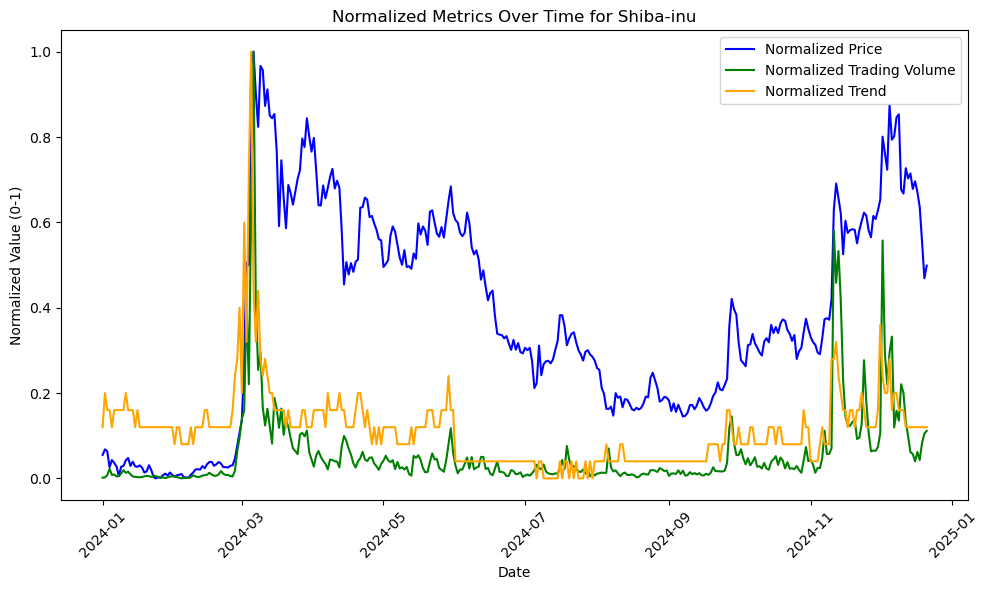

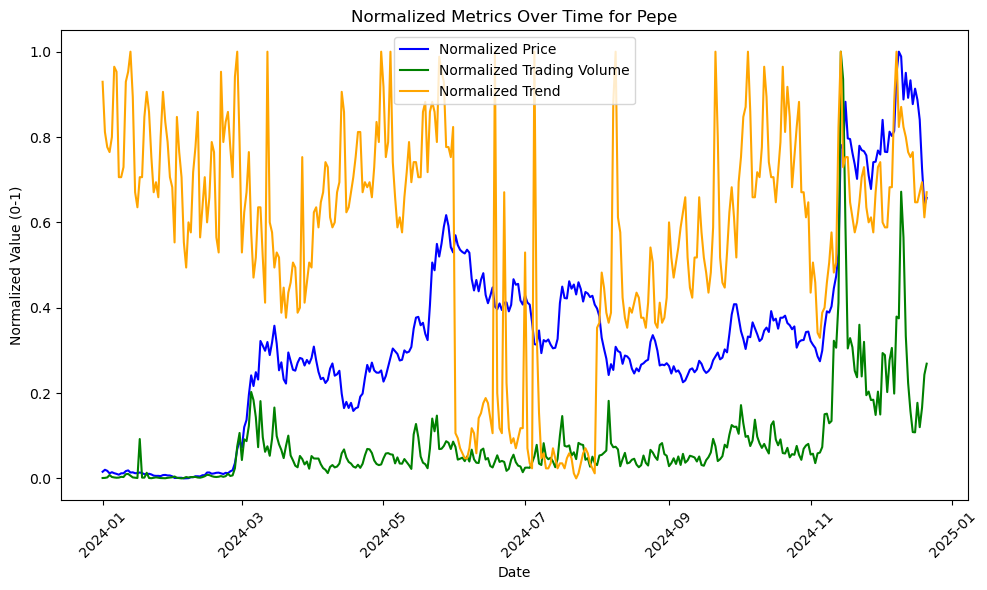

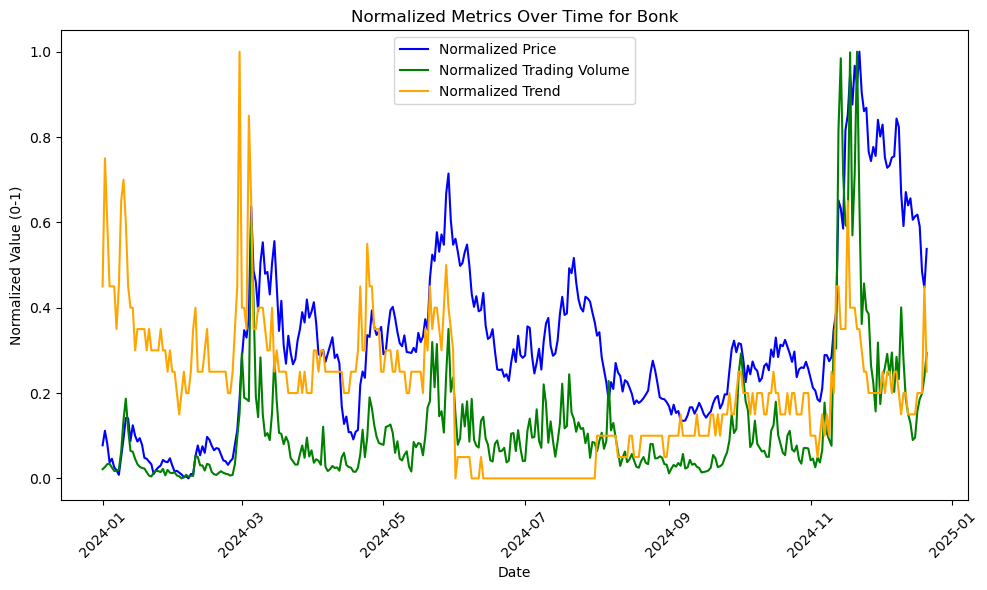

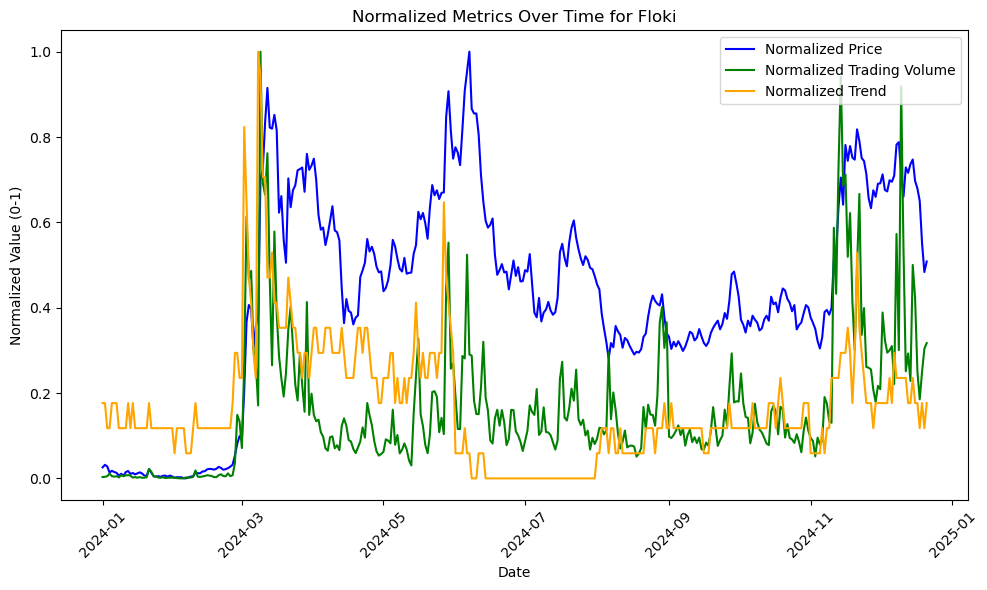

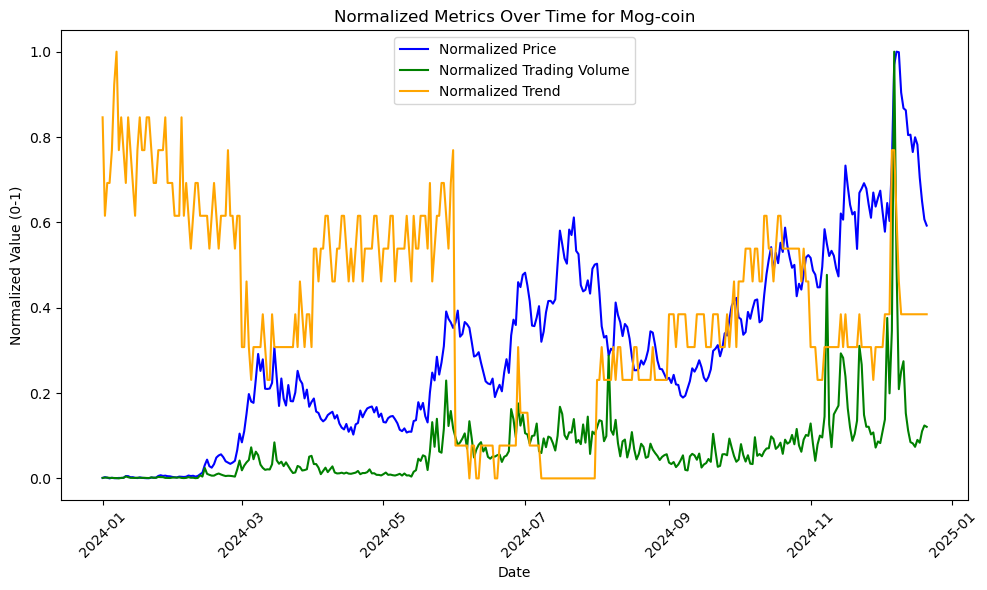

In [11]:
from sklearn.preprocessing import MinMaxScaler

# 初始化標準化工具
scaler = MinMaxScaler()

# 獲取所有唯一的 token_id
token_ids = merged_data["token_id"].unique()

# 為每個 token_id 繪製標準化的圖
for token in token_ids:
    token_data = merged_data[merged_data["token_id"] == token].copy()

    # 將數據標準化
    token_data[["price", "trading_volume", "trend"]] = scaler.fit_transform(
        token_data[["price", "trading_volume", "trend"]]
    )

    plt.figure(figsize=(10, 6))
    
    # 繪製標準化數據
    plt.plot(token_data["date"], token_data["price"], label="Normalized Price", color="blue")
    plt.plot(token_data["date"], token_data["trading_volume"], label="Normalized Trading Volume", color="green")
    plt.plot(token_data["date"], token_data["trend"], label="Normalized Trend", color="orange")
    
    # 設置標題和軸標籤
    plt.title(f"Normalized Metrics Over Time for {token.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value (0-1)")
    plt.xticks(rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{token}_normalized_metrics_over_time.png")  # 儲存圖表
    plt.show()


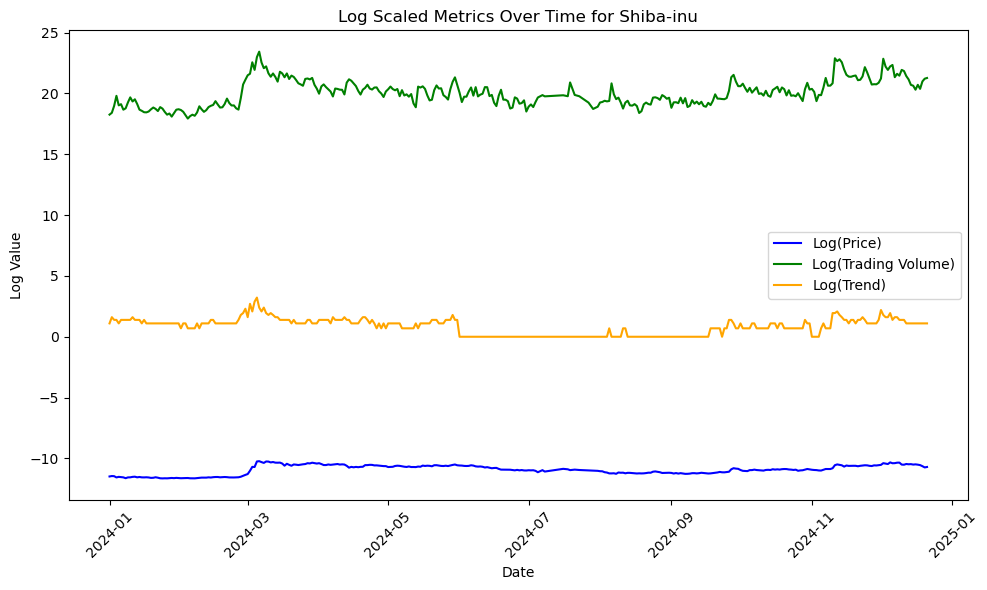

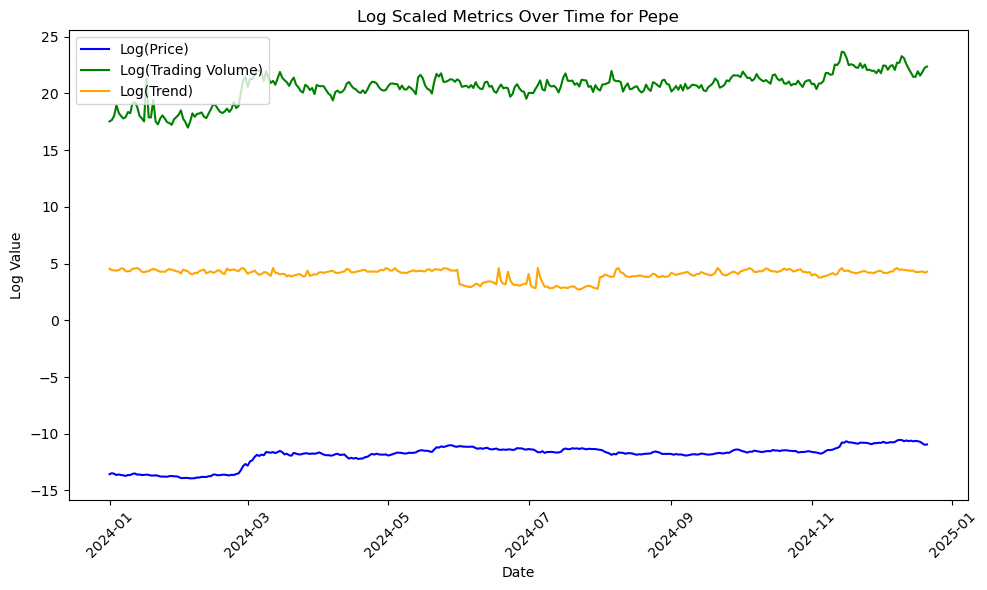

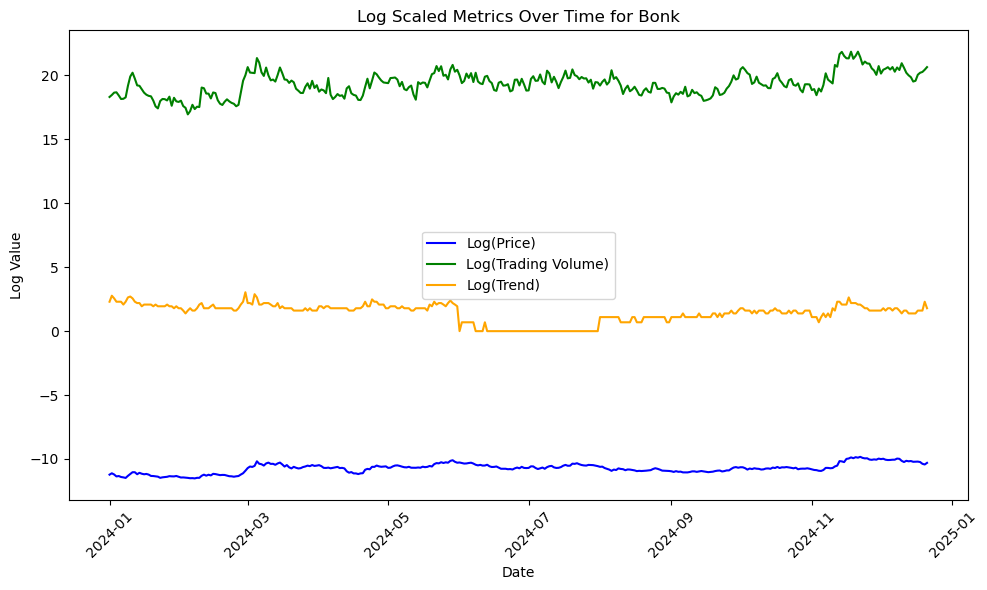

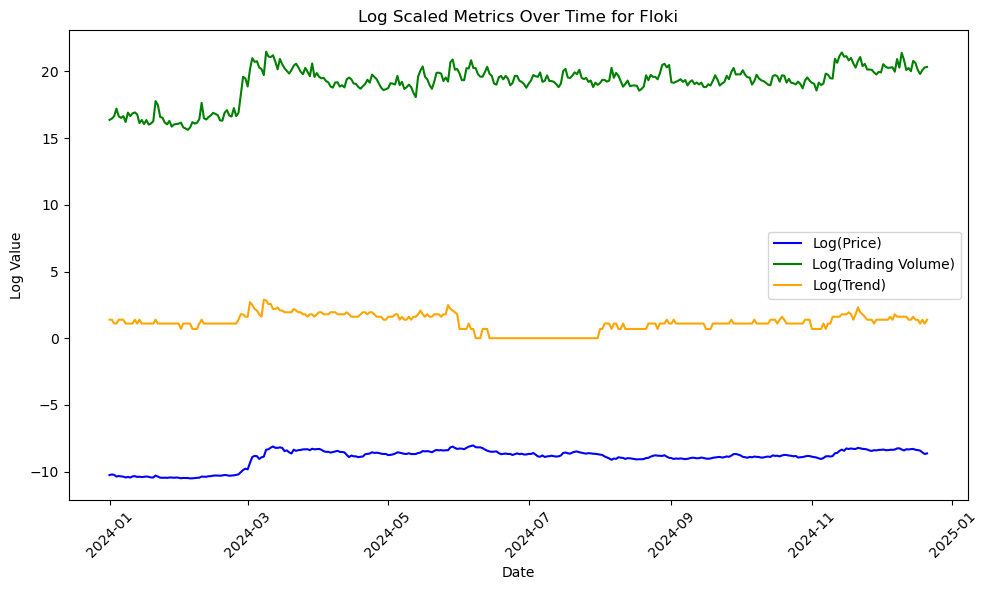

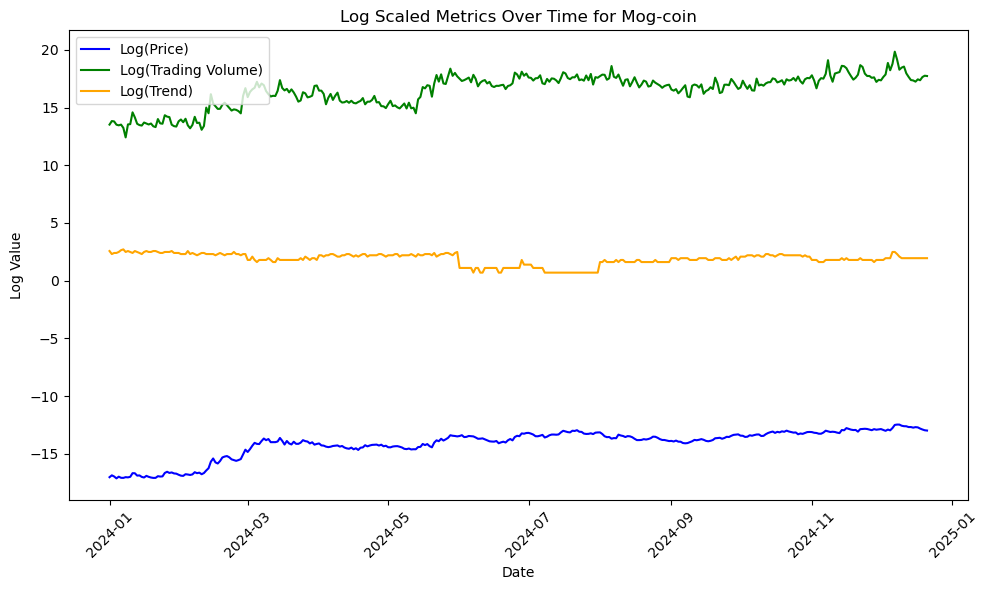

In [12]:
# 確保資料中不存在非正數，以避免取對數時出錯
merged_data = merged_data[(merged_data["price"] > 0) & (merged_data["trading_volume"] > 0) & (merged_data["trend"] > 0)]

# 取對數
merged_data["log_price"] = np.log(merged_data["price"])
merged_data["log_trading_volume"] = np.log(merged_data["trading_volume"])
merged_data["log_trend"] = np.log(merged_data["trend"])

# 為每個 token_id 繪製獨立的圖
for token in token_ids:
    token_data = merged_data[merged_data["token_id"] == token]
    
    plt.figure(figsize=(10, 6))
    
    # 繪製 log_price
    plt.plot(token_data["date"], token_data["log_price"], label="Log(Price)", color="blue")
    
    # 繪製 log_trading_volume
    plt.plot(token_data["date"], token_data["log_trading_volume"], label="Log(Trading Volume)", color="green")
    
    # 繪製 log_trend
    plt.plot(token_data["date"], token_data["log_trend"], label="Log(Trend)", color="orange")
    
    # 設置標題和軸標籤
    plt.title(f"Log Scaled Metrics Over Time for {token.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Log Value")
    plt.xticks(rotation=45)  # 日期標籤旋轉
    plt.legend()
    
    # 儲存圖表為檔案或顯示
    plt.tight_layout()
    plt.savefig(f"{token}_log_metrics_over_time.png")  # 儲存為檔案
    plt.show()  # 顯示圖表

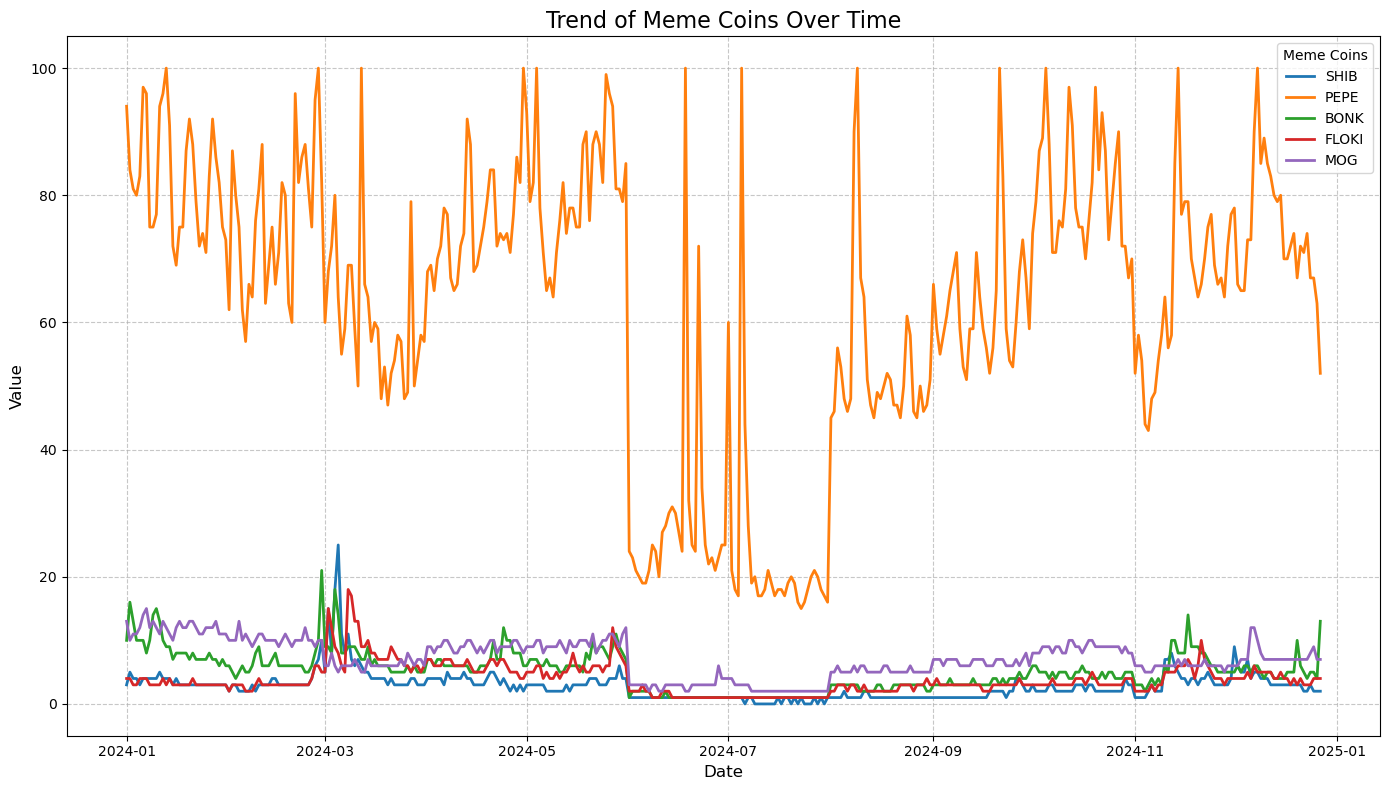

In [13]:
# 繪製折線圖
plt.figure(figsize=(14, 8))
for coin in ['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']:
    plt.plot(google_trends_data['date'], google_trends_data[coin], label=coin, linewidth=2)

# 添加標題和軸標籤
plt.title("Trend of Meme Coins Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)

# 添加圖例和網格
plt.legend(title="Meme Coins")
plt.grid(True, linestyle='--', alpha=0.7)

# 調整圖表佈局
plt.tight_layout()

#儲存圖表
plt.savefig("Trend of Meme Coins Over Time.png")

# 顯示圖表
plt.show()

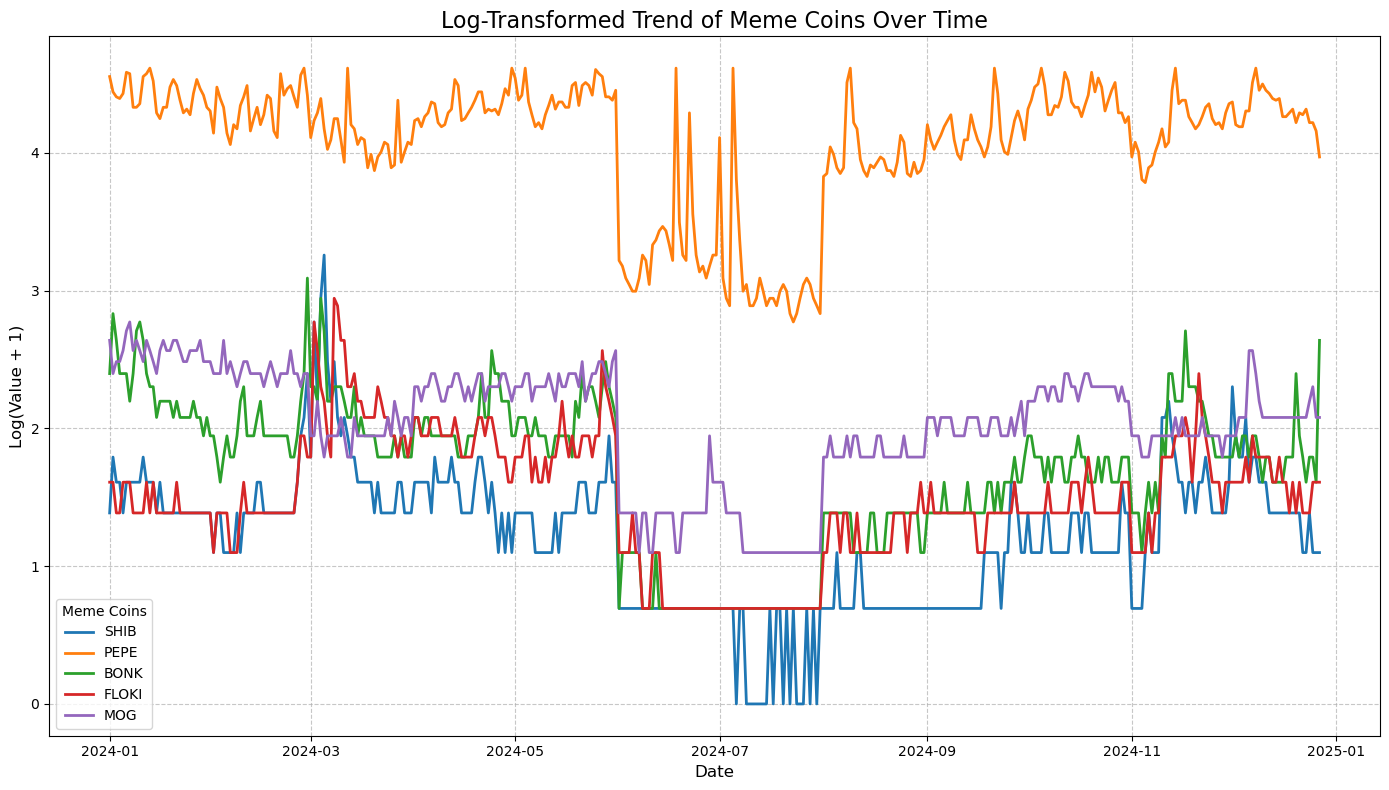

In [14]:
# 對數變換（避免 log(0) 錯誤，將值 +1）
google_trends_data_log = google_trends_data.copy()
for coin in ['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']:
    google_trends_data_log[coin] = np.log1p(google_trends_data[coin])  # log1p(x) 等於 log(x+1)
# 繪製折線圖
plt.figure(figsize=(14, 8))
for coin in ['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']:
    plt.plot(google_trends_data_log['date'], google_trends_data_log[coin], label=coin, linewidth=2)

# 添加標題和軸標籤
plt.title("Log-Transformed Trend of Meme Coins Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Log(Value + 1)", fontsize=12)

# 添加圖例和網格
plt.legend(title="Meme Coins")
plt.grid(True, linestyle='--', alpha=0.7)

# 調整圖表佈局
plt.tight_layout()

#儲存圖表
plt.savefig("Log-Transformed Trend of Meme Coins Over Time.png")

# 顯示圖表
plt.show()

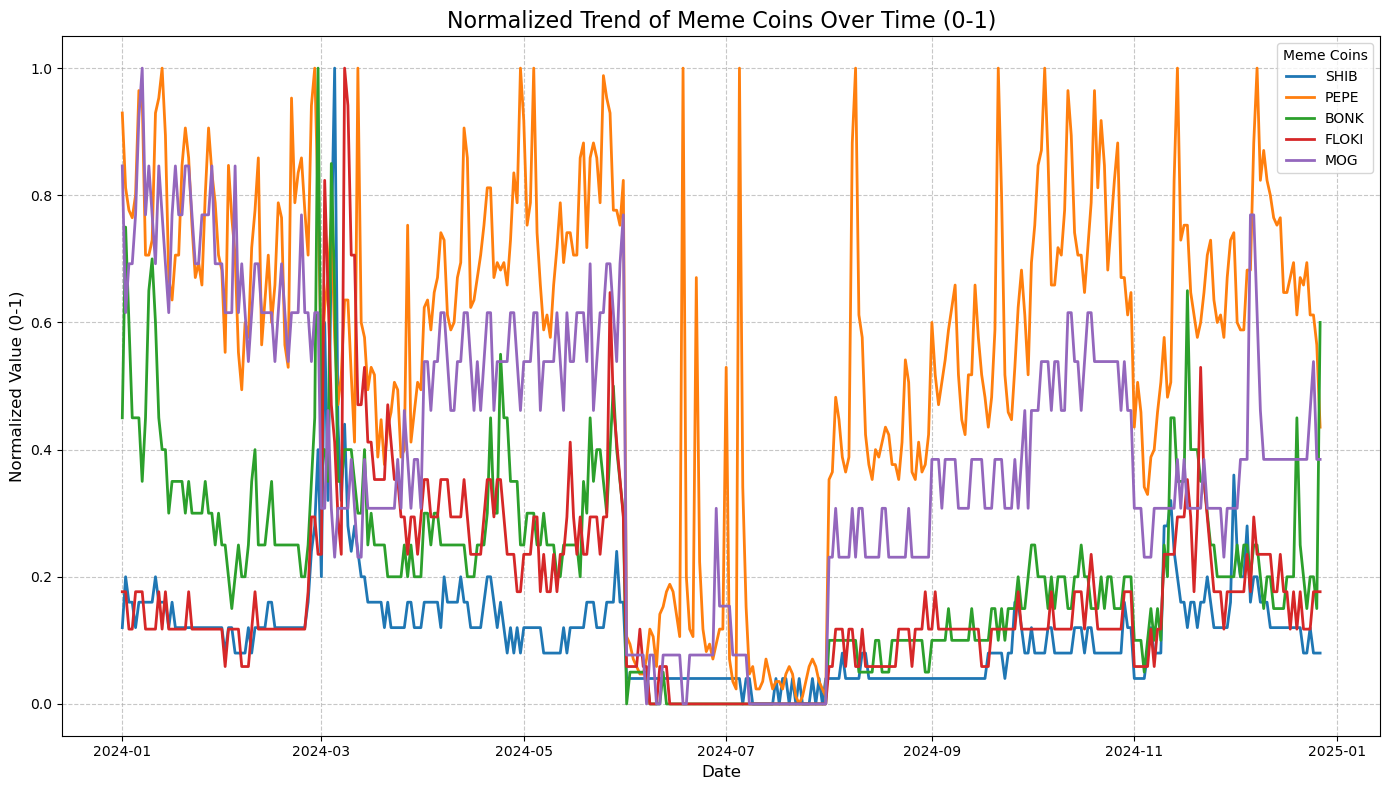

In [15]:
# 將需要的數據標準化到 0-1
normalized_data = google_trends_data.copy()
normalized_data[['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']] = scaler.fit_transform(
    google_trends_data[['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']]
)

# 繪製標準化後的折線圖
plt.figure(figsize=(14, 8))
for coin in ['SHIB', 'PEPE', 'BONK', 'FLOKI', 'MOG']:
    plt.plot(normalized_data['date'], normalized_data[coin], label=coin, linewidth=2)

# 添加標題和軸標籤
plt.title("Normalized Trend of Meme Coins Over Time (0-1)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Value (0-1)", fontsize=12)

# 添加圖例和網格
plt.legend(title="Meme Coins")
plt.grid(True, linestyle='--', alpha=0.7)

# 調整圖表佈局
plt.tight_layout()

# 儲存圖表
plt.savefig("Normalized_Trend_of_Meme_Coins_Over_Time.png")

# 顯示圖表
plt.show()

In [10]:
# 分群計算每個 token_id 的相關係數
grouped_correlation = {}

# 按 token_id 分群
for token in merged_data['token_id'].unique():
    token_data = merged_data[merged_data['token_id'] == token]
    
    # 計算相關係數矩陣
    corr_matrix = token_data[['price', 'trading_volume', 'trend']].corr()
    
    # 儲存結果
    grouped_correlation[token] = corr_matrix

# 輸出相關係數矩陣
for token, corr_matrix in grouped_correlation.items():
    print(f"Correlation matrix for {token}:\n{corr_matrix}\n")

Correlation matrix for shiba-inu:
                   price  trading_volume     trend
price           1.000000        0.543598  0.365059
trading_volume  0.543598        1.000000  0.631210
trend           0.365059        0.631210  1.000000

Correlation matrix for pepe:
                   price  trading_volume     trend
price           1.000000        0.672708 -0.143642
trading_volume  0.672708        1.000000  0.151011
trend          -0.143642        0.151011  1.000000

Correlation matrix for bonk:
                   price  trading_volume     trend
price           1.000000        0.737057  0.032744
trading_volume  0.737057        1.000000  0.262896
trend           0.032744        0.262896  1.000000

Correlation matrix for floki:
                   price  trading_volume     trend
price           1.000000        0.642937  0.300401
trading_volume  0.642937        1.000000  0.472558
trend           0.300401        0.472558  1.000000

Correlation matrix for mog-coin:
                   price 

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 添加日期相關特徵
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['month'] = merged_data['date'].dt.month
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

# 分組處理
datasets = {}
features = ['trading_volume', 'trend', 'month', 'day_of_week']

for token, group in merged_data.groupby('token_id'):
    # 特徵與目標變數
    X = group[features]
    y = group['price']
    
    # 標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 訓練集/測試集拆分
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # 保存每個 token 的數據集
    datasets[token] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

# 測試：檢查某個 token 的數據集
print(datasets['shiba-inu']['X_train'].shape)
print(datasets['shiba-inu']['y_train'].shape)

(284, 4)
(284,)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for token, data in datasets.items():
    model = LinearRegression()
    model.fit(data['X_train'], data['y_train'])
    y_pred = model.predict(data['X_test'])
    
    # 計算評估指標
    mse = mean_squared_error(data['y_test'], y_pred)
    mae = mean_absolute_error(data['y_test'], y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(data['y_test'], y_pred)
    
    # MAPE 計算時需避免除以 0
    mape = (abs((data['y_test'] - y_pred) / data['y_test']).mean() * 100 
            if not (data['y_test'] == 0).any() else float('inf'))
    
    print(f"{token} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

bonk - MSE: 0.000000, RMSE: 0.000007, MAE: 0.000005, MAPE: 23.39%, R²: 0.5888
floki - MSE: 0.000000, RMSE: 0.000055, MAE: 0.000049, MAPE: 58.03%, R²: 0.4757
mog-coin - MSE: 0.000000, RMSE: 0.000000, MAE: 0.000000, MAPE: 44.39%, R²: 0.8256
pepe - MSE: 0.000000, RMSE: 0.000003, MAE: 0.000003, MAPE: 56.15%, R²: 0.7233
shiba-inu - MSE: 0.000000, RMSE: 0.000006, MAE: 0.000005, MAPE: 31.70%, R²: 0.3327


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 建立並評估隨機森林模型
for token, data in datasets.items():
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(data['X_train'], data['y_train'])
    y_pred = model.predict(data['X_test'])
    
    # 計算評估指標
    mse = mean_squared_error(data['y_test'], y_pred)
    mae = mean_absolute_error(data['y_test'], y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(data['y_test'], y_pred)
    
    # MAPE 計算時需避免除以 0
    mape = (abs((data['y_test'] - y_pred) / data['y_test']).mean() * 100 
            if not (data['y_test'] == 0).any() else float('inf'))
    
    # 印出結果
    print(f"{token} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

bonk - MSE: 0.000000, RMSE: 0.000004, MAE: 0.000003, MAPE: 9.10%, R²: 0.8695
floki - MSE: 0.000000, RMSE: 0.000023, MAE: 0.000016, MAPE: 9.09%, R²: 0.9080
mog-coin - MSE: 0.000000, RMSE: 0.000000, MAE: 0.000000, MAPE: 17.65%, R²: 0.9180
pepe - MSE: 0.000000, RMSE: 0.000002, MAE: 0.000001, MAPE: 9.72%, R²: 0.9367
shiba-inu - MSE: 0.000000, RMSE: 0.000002, MAE: 0.000001, MAPE: 7.11%, R²: 0.9061


In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 訓練並評估每個代幣的 LSTM 模型
for token, data in datasets.items():
    # 將數據轉換為 LSTM 所需的 3D 格式
    X_train_seq = np.array(data['X_train']).reshape(data['X_train'].shape[0], 1, data['X_train'].shape[1])
    X_test_seq = np.array(data['X_test']).reshape(data['X_test'].shape[0], 1, data['X_test'].shape[1])
    print(X_train_seq)
    print(X_test_seq)
    
    # 建立 LSTM 模型
    model = Sequential([
        LSTM(10, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    
    # 編譯模型
    model.compile(optimizer='adam', loss='mse')
    
    # 訓練模型
    model.fit(X_train_seq, data['y_train'], epochs=50, batch_size=4, verbose=0)
    
    # 預測
    y_pred = model.predict(X_test_seq)
    
    # 計算評估指標
    mse = mean_squared_error(data['y_test'], y_pred)
    mae = mean_absolute_error(data['y_test'], y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(data['y_test'], y_pred)
    
    # MAPE 計算時需避免除以 0
    mape = (abs((data['y_test'] - y_pred.flatten()) / data['y_test']).mean() * 100 
            if not (data['y_test'] == 0).any() else float('inf'))
    
    # 印出結果
    print(f"{token} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")


[[[ 1.13078267 -0.04124764  1.67229312 -0.49666365]]

 [[ 0.74958481 -0.04124764  1.37581087  0.00422094]]

 [[-0.03188513 -1.3465062   0.18988189 -0.99754824]]

 ...

 [[-0.1925669  -0.04124764  0.78284638  0.50510553]]

 [[ 0.09137059 -0.36756228  1.67229312  1.00599012]]

 [[-0.68355202  0.285067   -0.69956485  0.50510553]]]
[[[-4.97735173e-01 -6.93876917e-01  4.86364134e-01  4.22093755e-03]]

 [[-5.95615028e-01  2.85067003e-01 -1.29252934e+00 -1.49843283e+00]]

 [[-6.20089461e-01 -3.67562277e-01  7.82846380e-01  5.05105527e-01]]

 [[-5.22230876e-01 -1.34650620e+00  1.89881888e-01 -1.49843283e+00]]

 [[-7.51594505e-01  2.85067003e-01 -1.29252934e+00 -1.49843283e+00]]

 [[ 2.84139430e-01 -4.12476371e-02  1.37581087e+00  5.05105527e-01]]

 [[-5.76796055e-01  9.37696283e-01 -1.58901159e+00 -9.97548241e-01]]

 [[-5.74536223e-01  9.37696283e-01 -1.29252934e+00 -9.97548241e-01]]

 [[ 3.47852366e-01  6.11381643e-01 -4.03082604e-01 -1.49843283e+00]]

 [[-4.30281296e-01 -3.67562277e-01  1.07

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
bonk - MSE: 0.000018, RMSE: 0.004252, MAE: 0.003114, MAPE: 12898.15%, R²: -175453.8249
[[[ 2.28302465  0.45247168  1.67229312 -0.49666365]]

 [[ 0.25925276 -0.36312284  1.37581087  0.00422094]]

 [[-0.32994865 -1.17871736  0.18988189 -0.99754824]]

 ...

 [[ 0.29609955  0.04467442  0.78284638  0.50510553]]

 [[ 0.38508011  0.04467442  1.67229312  1.00599012]]

 [[-0.60697021  0.86026894 -0.69956485  0.50510553]]]
[[[-5.44812781e-01 -7.70920099e-01  4.86364134e-01  4.22093755e-03]]

 [[-9.91092941e-01 -3.63122840e-01 -1.29252934e+00 -1.49843283e+00]]

 [[-5.05881487e-01 -3.63122840e-01  7.82846380e-01  5.05105527e-01]]

 [[-4.73515198e-01 -1.17871736e+00  1.89881888e-01 -1.49843283e+00]]

 [[-9.66504068e-01  4.46744188e-02 -1.29252934e+00 -1.49843283e+00]]

 [[ 8.30599220e-02  4.46744188e-02  1.37581087e+00  5.05105527e-01]]

 [[-1.00210402e+00 -3.63122840e-01 -1.58901159e+00 -9.97548241e-01]]

 [[-7.89719525e-01  8.60268936e-01 -1.29252934e+00 -9.9

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
floki - MSE: 0.000064, RMSE: 0.007995, MAE: 0.003324, MAPE: 2585.60%, R²: -10906.3633
[[[ 2.43937302 -0.06446353  1.67229312 -0.49666365]]

 [[ 0.46070922 -0.74950878  1.37581087  0.00422094]]

 [[ 0.40693607 -1.09203141  0.18988189 -0.99754824]]

 ...

 [[ 0.29058664 -0.40698616  0.78284638  0.50510553]]

 [[ 0.19231573 -0.06446353  1.67229312  1.00599012]]

 [[-0.67446719  0.62058173 -0.69956485  0.50510553]]]
[[[ 0.02650114 -0.74950878  0.48636413  0.00422094]]

 [[-0.7296138   0.96310436 -1.29252934 -1.49843283]]

 [[-0.29733519 -0.06446353  0.78284638  0.50510553]]

 [[ 0.43913644 -1.09203141  0.18988189 -1.49843283]]

 [[-0.7541662   0.96310436 -1.29252934 -1.49843283]]

 [[ 0.04065256 -0.40698616  1.37581087  0.50510553]]

 [[-0.79727713  1.64814961 -1.58901159 -0.99754824]]

 [[-0.76622728  0.62058173 -1.29252934 -0.99754824]]

 [[-0.58323205  0.62058173 -0.4030826  -1.49843283]]

 [[ 0.25970232  0.62058173  1.07932863 -1.49843283]]

 [[-0.

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
mog-coin - MSE: 0.000036, RMSE: 0.005983, MAE: 0.004719, MAPE: 2038311.69%, R²: -43215175.7015
[[[ 4.35895360e+00  9.48128796e-01  1.67229312e+00 -4.96663652e-01]]

 [[ 9.30213265e-01  1.73066189e-02  1.37581087e+00  4.22093755e-03]]

 [[-5.04874468e-01 -1.88866260e+00  1.89881888e-01 -9.97548241e-01]]

 ...

 [[ 1.89841989e-01  1.94606081e-01  7.82846380e-01  5.05105527e-01]]

 [[ 6.89811839e-01  6.82179603e-01  1.67229312e+00  1.00599012e+00]]

 [[-4.19236470e-01  4.60555275e-01 -6.99564851e-01  5.05105527e-01]]]
[[[-3.98417445e-01 -6.47566365e-01  4.86364134e-01  4.22093755e-03]]

 [[-7.18319940e-01 -2.70182467e-02 -1.29252934e+00 -1.49843283e+00]]

 [[-3.75663927e-01 -2.04317709e-01  7.82846380e-01  5.05105527e-01]]

 [[-5.07328740e-01 -1.59992843e-01  1.89881888e-01 -1.49843283e+00]]

 [[-6.69337838e-01  5.04880140e-01 -1.29252934e+00 -1.49843283e+00]]

 [[ 6.08414432e-01  3.71905544e-01  1.37581087e+00  5.05105527e-01]]

 [[-7.24741254e-01  2

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
pepe - MSE: 0.000010, RMSE: 0.003228, MAE: 0.002588, MAPE: 62785.83%, R²: -247267.5217
[[[ 1.40974609  0.50343086  1.67229312 -0.49666365]]

 [[ 0.07020926  0.07873563  1.37581087  0.00422094]]

 [[-0.48663238 -0.77065483  0.18988189 -0.99754824]]

 ...

 [[ 0.6063411   0.50343086  0.78284638  0.50510553]]

 [[ 0.0331258   0.07873563  1.67229312  1.00599012]]

 [[-0.32070397  0.92812609 -0.69956485  0.50510553]]]
[[[-4.98773941e-01 -7.70654826e-01  4.86364134e-01  4.22093755e-03]]

 [[-5.35385608e-01  7.87356324e-02 -1.29252934e+00 -1.49843283e+00]]

 [[-4.84703802e-01 -7.70654826e-01  7.82846380e-01  5.05105527e-01]]

 [[-5.08197697e-01 -7.70654826e-01  1.89881888e-01 -1.49843283e+00]]

 [[-5.31578942e-01  5.03430861e-01 -1.29252934e+00 -1.49843283e+00]]

 [[ 6.39685225e-02  7.87356324e-02  1.37581087e+00  5.05105527e-01]]

 [[-5.48029397e-01  5.03430861e-01 -1.58901159e+00 -9.97548241e-01]]

 [[-3.97648883e-01  1.35282132e+00 -1.29252934e+00 -9.9

C:\Users\wise\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
shiba-inu - MSE: 0.000043, RMSE: 0.006543, MAE: 0.004625, MAPE: 25573.38%, R²: -832607.0066


In [15]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 訓練並評估每個代幣的 ARIMA 模型
for token, data in datasets.items():
    # 因為 ARIMA 模型只適用於單一目標變數，因此我們只能用 'price' 來建模
    train_price = data['y_train']
    test_price = data['y_test']
    
    # 初始化 ARIMA 模型
    try:
        model = ARIMA(train_price, order=(1, 1, 1))  # (p, d, q): ARIMA 的參數
        model_fitted = model.fit()
        
        # 使用測試集進行預測
        forecast = model_fitted.forecast(steps=len(test_price))
        
        # 評估模型表現
        mse = mean_squared_error(test_price, forecast)
        mae = mean_absolute_error(test_price, forecast)
        rmse = mse ** 0.5
        r2 = r2_score(test_price, forecast)
        
        # MAPE 計算時需避免除以 0
        mape = (abs((test_price - forecast) / test_price).mean() * 100 
                if not (test_price == 0).any() else float('inf'))
        
        # 印出結果
        print(f"{token} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")
    except Exception as e:
        print(f"{token} - ARIMA model failed: {str(e)}")

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


bonk - MSE: 0.000000, RMSE: 0.000010, MAE: 0.000008, MAPE: 46.97%, R²: -0.0135
floki - MSE: 0.000000, RMSE: 0.000085, MAE: 0.000067, MAPE: 185.80%, R²: -0.2249
mog-coin - MSE: 0.000000, RMSE: 0.000001, MAE: 0.000001, MAPE: 429.84%, R²: -0.0135
pepe - MSE: 0.000650, RMSE: 0.025491, MAE: 0.025491, MAPE: 924284.98%, R²: -15414892.7402
shiba-inu - MSE: 0.000000, RMSE: 0.000009, MAE: 0.000007, MAPE: 69.74%, R²: -0.4063


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [42]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 訓練並評估每個代幣的 XGBoost 模型
for token, data in datasets.items():
    # 初始化 XGBoost 模型
    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # 損失函數
        n_estimators=100,             # 樹的數量
        learning_rate=0.1,            # 學習率
        max_depth=6,                  # 樹的最大深度
        random_state=42               # 隨機種子
    )
    
    # 訓練模型
    model.fit(data['X_train'], data['y_train'])
    
    # 預測測試集
    y_pred = model.predict(data['X_test'])
    
    # 計算評估指標
    mse = mean_squared_error(data['y_test'], y_pred)
    mae = mean_absolute_error(data['y_test'], y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(data['y_test'], y_pred)
    
    # MAPE 計算時需避免除以 0
    mape = (abs((data['y_test'] - y_pred) / data['y_test']).mean() * 100 
            if not (data['y_test'] == 0).any() else float('inf'))
    
    # 印出結果
    print(f"{token} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

ModuleNotFoundError: No module named 'xgboost'